






<h2 id='part1'>Airbnb: Boston vs. Seattle Analysis</h2>

In order to get a better understanding of the which market is better and more affordable, let's take a look at some of the characteristics of the dataset.

#### Data Summary

There are 3 datasets from Airbnb:

1. calendar.csv - data with availability dates, price for each date.
2. listings.csv - data about listing specific information
3. reviews.csv - data about review specific information

I will not use the reviews dataset since some of that information is already contained in the listings dataset

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as datetime
from datetime import datetime
import calendar
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


%matplotlib inline

#read in data
Boston_Calendar = pd.read_csv('./Data/Boston/calendar.csv')
Boston_Listings = pd.read_csv('./Data/Boston/listings.csv')
Boston_Reviews = pd.read_csv('./Data/Boston/reviews.csv')

Seattle_Calendar = pd.read_csv('./Data/Seattle/calendar.csv')
Seattle_Listings = pd.read_csv('./Data/Seattle/listings.csv')
Seattle_Reviews = pd.read_csv('./Data/Seattle/reviews.csv')

#remove dollar sign from price and rename
Boston_Calendar['price'] = Boston_Calendar['price'].astype(str)
Boston_Calendar['pricepaid'] = Boston_Calendar['price'].str.replace("[$, ]", "").astype("float")

Seattle_Calendar['price'] = Seattle_Calendar['price'].astype(str)
Seattle_Calendar['pricepaid'] = Seattle_Calendar['price'].str.replace("[$, ]", "").astype("float")
#drop old column
Boston_Calendar = Boston_Calendar.drop(columns = 'price')
Seattle_Calendar = Seattle_Calendar.drop(columns = 'price')

Boston_Calendar['month'] = Boston_Calendar.apply(lambda Boston_Calendar: int(Boston_Calendar['date'].split('-')[1]),axis=1)
Boston_Calendar['weekday'] = Boston_Calendar.apply(lambda Boston_Calendar: calendar.day_name[datetime.strptime(Boston_Calendar['date'], '%Y-%m-%d').weekday()],axis=1)

Seattle_Calendar['month'] = Seattle_Calendar.apply(lambda Seattle_Calendar: int(Seattle_Calendar['date'].split('-')[1]),axis=1)
Seattle_Calendar['weekday'] = Seattle_Calendar.apply(lambda Seattle_Calendar: calendar.day_name[datetime.strptime(Seattle_Calendar['date'], '%Y-%m-%d').weekday()],axis=1)

#remove some columns from the listings dataset we don't need for analysis-this will make the dataset more manageable
drop_columns = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 
        'host_about', 'market'   ,'has_availability',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'street', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
        'calendar_last_scraped',
       'review_scores_location',  'requires_license', 
       'license', 'jurisdiction_names', 'weekly_price'  ,
        'monthly_price' , 'security_deposit' ,
    
        'host_since','host_location','first_review','last_review' ,
       'require_guest_profile_picture','host_verifications', 
       'require_guest_phone_verification', 'calculated_host_listings_count']
Seattle_Listings = Seattle_Listings.drop(columns = drop_columns)
Boston_Listings = Boston_Listings.drop(columns = drop_columns)

#drop some column form boston not present in seattle
drop_columns = ['access'  ,'interaction'  ,'house_rules' ]
Boston_Listings = Boston_Listings.drop(columns = drop_columns)


#take dollar sign out of some prices
Seattle_Listings['price'] = Seattle_Listings['price'].astype(str)
Seattle_Listings['price'] = Seattle_Listings['price'].str.replace("[$, ]", "").astype("float")

Boston_Listings['price'] = Boston_Listings['price'].astype(str)
Boston_Listings['price'] = Boston_Listings['price'].str.replace("[$, ]", "").astype("float")

Seattle_Listings['cleaning_fee'] = Seattle_Listings['cleaning_fee'].astype(str)
Seattle_Listings['cleaning_fee'] = Seattle_Listings['cleaning_fee'].str.replace("[$, ]", "").astype("float")

Boston_Listings['cleaning_fee'] = Boston_Listings['cleaning_fee'].astype(str)
Boston_Listings['cleaning_fee'] = Boston_Listings['cleaning_fee'].str.replace("[$, ]", "").astype("float")


#take percentage sign out of some variables
Seattle_Listings['host_response_rate'] = Seattle_Listings['host_response_rate'].astype(str)
Seattle_Listings['host_response_rate'] = Seattle_Listings['host_response_rate'].str.replace("[%, ]", "").astype("float")

Boston_Listings['host_response_rate'] = Boston_Listings['host_response_rate'].astype(str)
Boston_Listings['host_response_rate'] = Boston_Listings['host_response_rate'].str.replace("[%, ]", "").astype("float")



Seattle_Listings['host_acceptance_rate'] = Seattle_Listings['host_acceptance_rate'].astype(str)
Seattle_Listings['host_acceptance_rate'] = Seattle_Listings['host_acceptance_rate'].str.replace("[%, ]", "").astype("float")

Boston_Listings['host_acceptance_rate'] = Boston_Listings['host_acceptance_rate'].astype(str)
Boston_Listings['host_acceptance_rate'] = Boston_Listings['host_acceptance_rate'].str.replace("[%, ]", "").astype("float")

In [208]:
Seattle_Calendar.head()

,listing_id,date,available,pricepaid,month,weekday
0,241032,2016-01-04,t,85.0,1,Monday
1,241032,2016-01-05,t,85.0,1,Tuesday
2,241032,2016-01-06,f,NaN,1,Wednesday
3,241032,2016-01-07,f,NaN,1,Thursday
4,241032,2016-01-08,f,NaN,1,Friday


## Summary of Calendar Dataset

In Boston, there are 3585 unique listings. The date range is from 2016-09-06 to 2017-09-05.
Listings have an average price of $198
In Seattle, there are 3818 unique listings. The date range is from 2016-01-04 to 2017-01-02.
Listings have an average price of $137


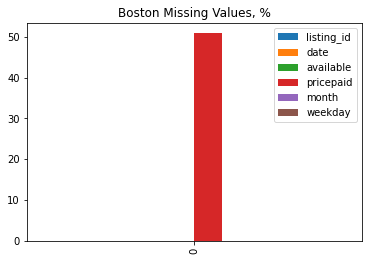

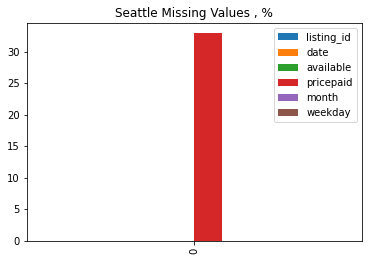

In [209]:
#find number of listings and number of hosts
print('In Boston, there are %d unique listings. The date range is from %s to %s.' % (len(Boston['listing_id'].unique()), Boston['date'].min(),Boston['date'].max()))
print('Listings have an average price of $%d' % (Boston['pricepaid'].mean().round(2)))


missing_BOS = pd.DataFrame([Boston_Calendar.isnull().mean()*100])
missing_BOS.plot.bar(title='Boston Missing Values, %')

print('In Seattle, there are %d unique listings. The date range is from %s to %s.' % (len(Seattle['listing_id'].unique()), Seattle['date'].min(),Seattle['date'].max()))
print('Listings have an average price of $%d' % (Seattle['pricepaid'].mean().round(2)))

#missing percent by column
missing_SEA = pd.DataFrame([Seattle_Calendar.isnull().mean()*100])
missing_SEA.plot.bar(title='Seattle Missing Values , %')

## Summary of Listings Dataset

In Boston, there are 3585 unique listings in 31 neighborhoods.
On average, listings have 1 bedroom and 1 bathroom with a minimum stay of 3 days.


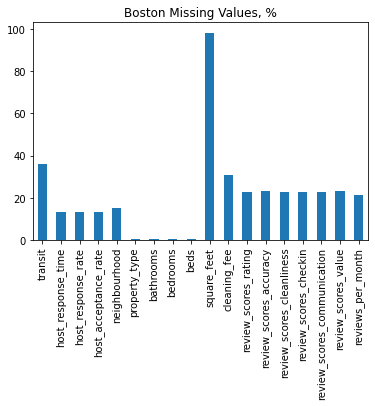

In Seattle, there are 3818 unique listings in 82 neighborhoods.
On average, listings have 1 bedroom and 1 bathroom with a minimum stay of 2 days.


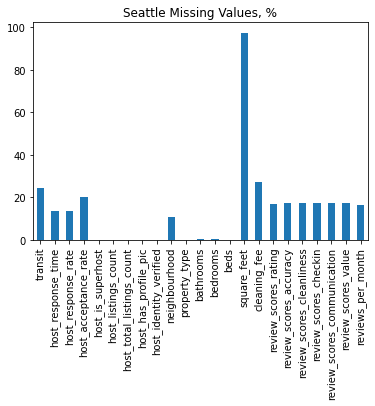

In [210]:
#find number of listings and number of hosts
print('In Boston, there are %d unique listings in %d neighborhoods.' % (len(Boston_Listings['id'].unique()), len(Boston_Listings['neighbourhood'].unique())))
print('On average, listings have %d bedroom and %d bathroom with a minimum stay of %d days.' % (Boston_Listings['bedrooms'].mean(), Boston_Listings['bathrooms'].mean(),Boston_Listings['minimum_nights'].mean()))


#find percentage of missing values for each column
missingBoston = Boston_Listings.isnull().mean()*100
#only look at with missing values because so many columns
missingBoston = missingBoston[missingBoston > 0]
missingBoston.plot.bar(title='Boston Missing Values, %')
plt.show()



print('In Seattle, there are %d unique listings in %d neighborhoods.' % (len(Seattle_Listings['id'].unique()), len(Seattle_Listings['neighbourhood'].unique())))
print('On average, listings have %d bedroom and %d bathroom with a minimum stay of %d days.' % (Seattle_Listings['bedrooms'].mean(), Seattle_Listings['bathrooms'].mean(),Seattle_Listings['minimum_nights'].mean()))

#find percentage of missing values for each column
missingSeattle = Seattle_Listings.isnull().mean()*100
#only look at with missing values because so many columns
missingSeattle = missingSeattle[missingSeattle > 0]
missingSeattle.plot.bar(title='Seattle Missing Values, %')
plt.show()

#### Imputing Values

We will impute the following ways:

* For categorical variables, impute based on most common elements
* For numeric, impute with median
* later on, we will create dummy variables for categorical when we model

In [211]:
def fillnaCategorical(var):
    '''
    INPUT
    var- name of  variable
  
    OUTPUT
    Imputed datasets
    
    This function cleans df using the following steps to produce a cleaned variable:
    1. Finds most common attribute of variable
    2. Fills NA with that variable
    '''   
    #This function fills NAs in categorical with most common element
    #group by var
    Boston_Listings[var]=Boston_Listings[var].fillna(Boston_Listings[var].value_counts().index[0])
    Seattle_Listings[var]=Seattle_Listings[var].fillna(Seattle_Listings[var].value_counts().index[0])
    return(Boston_Listings,Seattle_Listings)


Boston_Listings,Seattle_Listings=fillnaCategorical('neighbourhood')
Boston_Listings,Seattle_Listings=fillnaCategorical('host_response_time')
Boston_Listings,Seattle_Listings=fillnaCategorical('property_type')
Boston_Listings,Seattle_Listings=fillnaCategorical('host_identity_verified')
Boston_Listings,Seattle_Listings=fillnaCategorical('host_is_superhost')
Boston_Listings,Seattle_Listings=fillnaCategorical('host_has_profile_pic')


# Fill numeric columns with the mean
num_vars = Seattle_Listings.select_dtypes(include=['float', 'int']).columns

for col in num_vars:
    Seattle_Listings[col].fillna((Seattle_Listings[col].median()), inplace=True)
    Boston_Listings[col].fillna((Boston_Listings[col].median()), inplace=True)

### Create Dataset with Both Boston and Seattle so we can compare together

In [212]:
#combine datasets into one 
#create one big dataset
Boston = pd.merge(Boston_Calendar, Boston_Listings, left_on='listing_id', right_on='id')
Seattle = pd.merge(Seattle_Calendar, Seattle_Listings, left_on='listing_id', right_on='id')
Boston['city']='Boston'
Seattle['city']='Seattle'
All_Data=Boston.append(Seattle, ignore_index=True)
All_Data['transit']=All_Data['transit'].notnull()
All_Data['EntireHome']=All_Data['room_type']=='Entire home/apt'

Boston_Listings['city']='Boston'
Seattle_Listings['city']='Seattle'
ListingIDs=Boston_Listings.append(Seattle_Listings, ignore_index=True)
ListingIDs['transit']=ListingIDs['transit'].notnull()
ListingIDs['EntireHome']=ListingIDs['room_type']=='Entire home/apt'



#### Histogram of Prices Paid- Difference by City

/Users/nicholasreimold/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/nicholasreimold/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


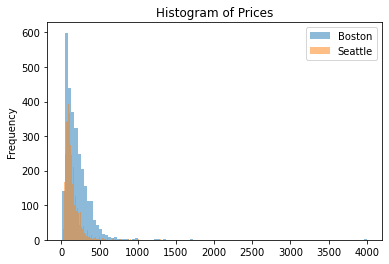

In [213]:
df = pd.DataFrame(All_Data.groupby(['listing_id','city']).mean()['pricepaid'])
df=df.reset_index()

x1 = df[df['city']=='Seattle']
x2 = df[df['city']=='Boston']

kwargs = dict(alpha=0.5, bins=100)

plt.hist(x2['pricepaid'], **kwargs,  label='Boston')
plt.hist(x1['pricepaid'], **kwargs,  label='Seattle')
plt.gca().set(title='Histogram of Prices', ylabel='Frequency')
plt.legend();

## How is the Rating Distribution Between Cities?

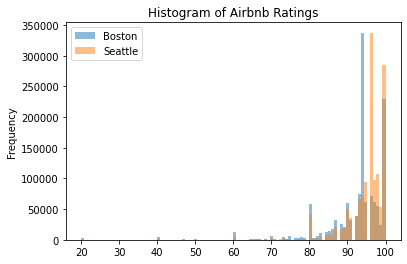

In [214]:
df = pd.DataFrame(All_Data.groupby(['listing_id','city']).mean()['pricepaid'])
df=df.reset_index()

x1 = All_Data[All_Data['city']=='Seattle']
x2 = All_Data[All_Data['city']=='Boston']

kwargs = dict(alpha=0.5, bins=100)

plt.hist(x2['review_scores_rating'], **kwargs,  label='Boston')
plt.hist(x1['review_scores_rating'], **kwargs,  label='Seattle')
plt.gca().set(title='Histogram of Airbnb Ratings', ylabel='Frequency')
plt.legend();

# When should we visit each city?

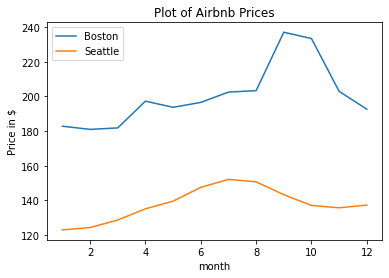

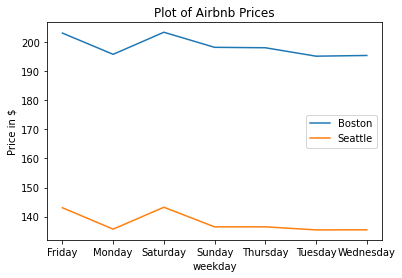

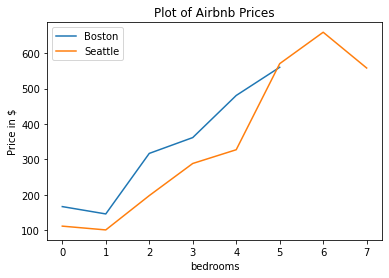

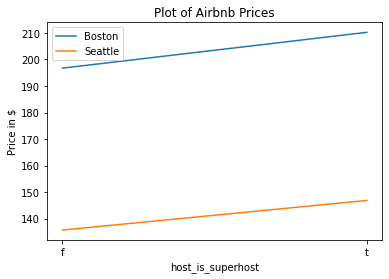

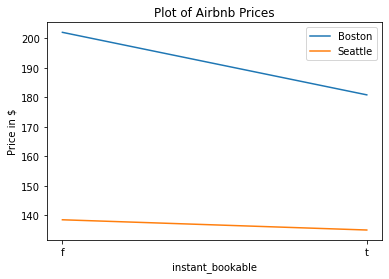

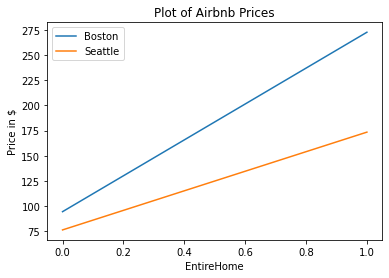

In [215]:
def Lineplot(All_Data,var,target):
    '''
    INPUT
    All_Data - pandas dataframe 
    var- name of grouping variable
    target- name of target
    
    OUTPUT
    Line Plot
    
    This function cleans df using the following steps to produce a lineplot:
    1. groups by appropriate grouping variable
    2. If it is weekday, sorts the days appropriately
    3. Creates Plot
    '''   
    #group by var
    df = pd.DataFrame(All_Data.groupby([var,'city']).mean()[target])
    df=df.reset_index()
    

    #order dataframe if it's by weekday
    if var=='weekday':
        cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        df['weekday'] = pd.Categorical(df['weekday'], categories=cats, ordered=True)
        df = df.sort_values('weekday')


    
    #split by city
    x1 = All_Data[All_Data['city']=='Seattle']
    x2 = All_Data[All_Data['city']=='Boston']

    #create a line plot of the two cities
    kwargs = dict(alpha=0.5, bins=100)
    plt.figure();
    plt.plot(x2.groupby([var])[target].mean(), label='Boston')
    plt.plot(x1.groupby([var])[target].mean(), label='Seattle')
    plt.gca().set(title='Plot of Airbnb Prices', ylabel='Price in $',xlabel=var)
    plt.legend();

    
Lineplot(All_Data,'month','pricepaid')  
Lineplot(All_Data,'weekday','pricepaid')  
Lineplot(All_Data,'bedrooms','pricepaid')  
Lineplot(All_Data,'host_is_superhost','pricepaid')  
Lineplot(All_Data,'instant_bookable','pricepaid')  
Lineplot(All_Data,'EntireHome','pricepaid')  



# What features most influence the price of a listing?
We want to look at listings to see if they are priced differently to those actually booked.

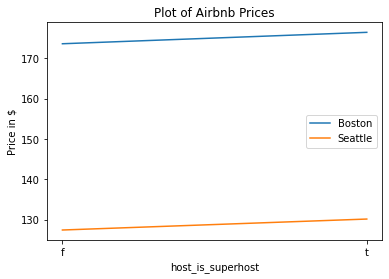

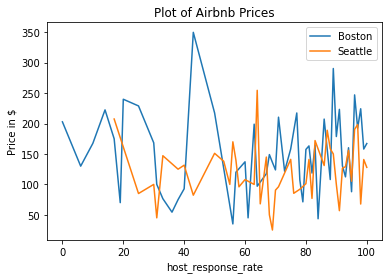

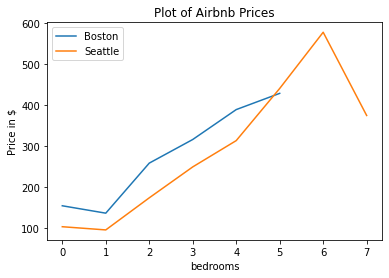

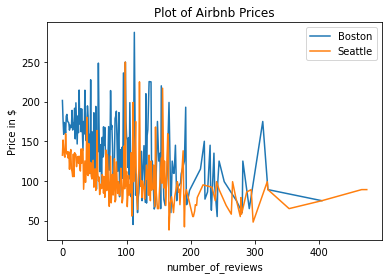

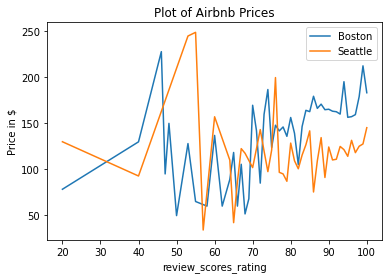

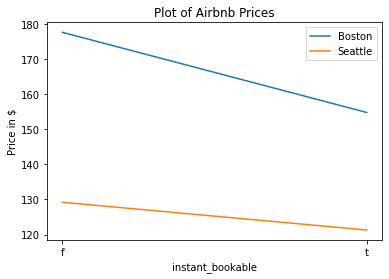

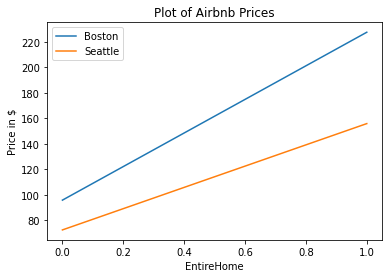

In [216]:
Lineplot(ListingIDs,'host_is_superhost','price')  
Lineplot(ListingIDs,'host_response_rate','price')  
Lineplot(ListingIDs,'bedrooms','price')  
Lineplot(ListingIDs,'number_of_reviews','price')  
Lineplot(ListingIDs,'review_scores_rating','price')  
Lineplot(ListingIDs,'instant_bookable','price')  
Lineplot(ListingIDs,'EntireHome','price')  

# Can we predict whether someone will book?

### First we will select columns we can and separate the target variable

In [217]:
All_Data['Booked']=All_Data['pricepaid']>0
y = All_Data['Booked']


drop_columns=['listing_id', 'date', 'available', 'pricepaid', 'is_location_exact',
       'accommodates',  'amenities', 'square_feet', 
       'guests_included', 'extra_people', 'id',
       'calendar_updated', 'availability_30', 'availability_60',
       'availability_90', 'availability_365','Booked']


X = All_Data.drop(columns = drop_columns)
#get dummies variables for categorical
X=pd.get_dummies(X)

## Fit A Logistic Model

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.20, random_state=42)
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Find the cross validation score as well as the general train test score


In [219]:
#not running cross validation due to time to run- performance is about same as test set
#kfold = KFold(n_splits=5, shuffle=True, random_state=42)
#scores = cross_val_score(log_model, X_train, y_train,cv=kfold)


#print("cross val score %f" % scores.mean())

print("train set score of logistic regression: %f" % log_model.score(X_train, y_train))
print("test set score of logistic regression: %f" % log_model.score(X_test, y_test))


train set score of logistic regression: 0.596614
test set score of logistic regression: 0.597485


## Let's do a grid search to see if we can make it better- also see the best predictors

In [231]:
#logreg- Small C (a lot of regularization) limits the influence of individual points!
param_grid = {'C': np.logspace(-3, 3, 7)}
param_grid

#initiate grid
grid = GridSearchCV(LogisticRegression(), param_grid,
                    return_train_score=True,cv=None)

#score grid on dataset
grid.fit(X_train, y_train)
grid.predict(X_test)
grid.score(X_test, y_test)
grid.best_estimator_

print(grid.best_params_)
print("best score: %f" % grid.best_score_)

# some visualization
%matplotlib inline
res = pd.DataFrame(grid.cv_results_)
res.mean_test_score.plot()
res.mean_train_score.plot()
plt.xscale("log")

grid.score(X_test, y_test)


{'C': 1000.0}
best score: 0.594320


### Most Important Features of Logistic Regression

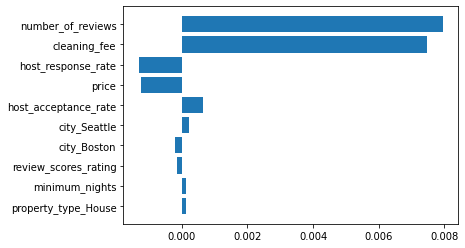

In [223]:
#plot most important predictors
important = np.argsort(np.abs(grid.best_estimator_.coef_)).ravel()

plt.barh(range(10), grid.best_estimator_.coef_.ravel()[important[-10:]])
plt.yticks(range(10), X_train.columns[important[-10:]]);

## Fit a Random Forest Model
Logistic Regression didn't fit the data too well, let's see if we can do better with a random forest

In [221]:
model=RandomForestClassifier()
model.fit(X_train, y_train)

print("train set score of random forest: %f" % model.score(X_train, y_train))
print("test set score of random forest: %f" % model.score(X_test, y_test))

train set score of random forest: 0.970215
test set score of random forest: 0.954664


### Most Important Features of Random Forest

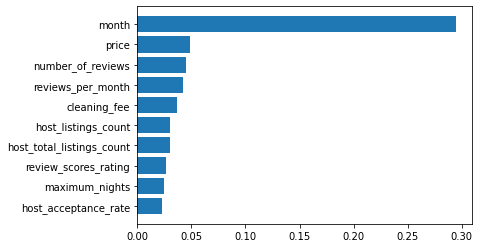

In [230]:
important=np.argsort(np.abs(model.feature_importances_)).ravel()

plt.barh(range(10), model.feature_importances_.ravel()[important[-10:]])
plt.yticks(range(10), X_train.columns[important[-10:]]);